# Zillow Time Series Analysis Project

In this project, I hope to scrape and gather data on home listings in the Cypress, CA region in order to glean some insight in house sales and understand whether or not a specific home would be considered a good investment. Suppose you are in the market to purchase a home, a real estate agent who wants to give data driven insight to their customer on a particular property, or an investor looking at what kind of property they should look into purchasing. I hope to provide some visualizations on exploratory analysis as well as a model that might be able to predict whether or not a particular home should be purchased at a given price. 

## Data Collection:

We will be webscraping zillow to gather our data of interest. The first thing we will want to do is make sure that we have requests and beautifulsoup4 installed.

In [4]:
pip install httpx pandas

Note: you may need to restart the kernel to use updated packages.


Using and adapting some code from this scrapfly code, we can scrape the zillow website by setting up a search query with map coordinates. We will receive up to 500 listings. We can use this code to receive two separate queries: one for the current listings in a specified area, and a second one to find the past 500 recently sold listings. 

In this example, we will be looking at data from Cypress, CA. 

Source Code: https://github.com/scrapfly/scrapfly-scrapers/tree/main/zillow-scraper

In [1]:
from urllib.parse import urlencode
import json
import httpx

# we should use browser-like request headers to prevent being instantly blocked
my_headers = {
    "accept-language": "en-US,en;q=0.9",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    "accept-language": "en-US;en;q=0.9",
    "accept-encoding": "gzip, deflate, br",
}

url = "https://www.zillow.com/search/GetSearchPageState.htm?"
parameters = {
    "searchQueryState": {
        "pagination": {},
        "usersSearchTerm": "Cypress, CA",
        # map coordinates that indicate Cypress city's area
        "mapBounds": {
            "west": -118.082105,
            "east": -118.001395,
            "south": 33.779917,
            "north": 33.858665,
        },
    },
    "wants": {
        "cat1": ["listResults", "mapResults"]
    },
    "requestId": 2,
}

response = httpx.get(url + urlencode(parameters), headers=my_headers)
assert response.status_code == 200, "request has been blocked"

current_listings = response.json()["cat1"]["searchResults"]["mapResults"]

#print(json.dumps(current_listings, indent=2))
#print(f"found {len(current_listings)} current property results")

In [2]:
url = "https://www.zillow.com/search/GetSearchPageState.htm?"
parameters = {
    "searchQueryState": {
        "pagination": {},
        "usersSearchTerm": "Cypress, CA",
        # map coordinates that indicate New Haven city's area
        "mapBounds": {
            "west": -118.082105,
            "east": -118.001395,
            "south": 33.779917,
            "north": 33.858665,
        },
        "regionSelection":[{"regionId":44833,"regionType":6}],
        "isMapVisible":False,
        "filterState":{
            "sortSelection":{"value":"globalrelevanceex"},
            "isAllHomes":{"value":True},
            "isRecentlySold":{"value":True},
            "isForSaleByAgent":{"value":False},
            "isForSaleByOwner":{"value":False},
            "isNewConstruction":{"value":False},
            "isComingSoon":{"value":False},
            "isAuction":{"value":False},
            "isForSaleForeclosure":{"value":False}
        },
        "isListVisible":True,"mapZoom":13
    },
    "wants": {
        "cat1": ["listResults", "mapResults"]
    },
    "requestId": 2,
}

response = httpx.get(url + urlencode(parameters), headers=my_headers)
assert response.status_code == 200, "request has been blocked"

sold_listings = response.json()["cat1"]["searchResults"]["mapResults"]

#print(json.dumps(sold_listings, indent=2))
#print(f"found {len(sold_listings)} recently sold property results")

## Data Cleaning

We currently have two dictionaries "current_dict" and "sold_dict" that store the json data in dictionaries. We also have two lists "current_listings" and "sold_listings" that store the json data in lists. There is a lot of information here that we don't necessarily need for our exploratory data needs. The ones we are currently interested in are the address, price, number of bed/bath, living area in square feet, lot area in square feet, sold/listed date, and home type. Let's take a look at what the dictionaries and the listings look like. 

In [3]:
import pandas as pd

# these keys are the data points of interest. 
keys = ["streetAddress", "zipcode", "price", "dateSold", "bathrooms", "bedrooms", "livingArea", "lotAreaValue", "homeType"]
sold_dict = {} # final dictionary that holds all sold listings.
listing = {} # temporary dictionary that will store the desired information from each listing.
skipped_sold = []
for i in range(0, len(sold_listings)):
    # sometimes, a listing is a building with many units available for rent. These have no price listed, nor data for each individual unit. 
    if sold_listings[i].get("isBuilding", False) == False: 
        for key in keys:
            listing[key] = sold_listings[i]["hdpData"]["homeInfo"].get(key, None) 
        sold_dict[i] = listing
        #print("added " + str(i+1) + " listings")
    else:
        # for the buildings, we store the url of each individual building in a list. If we want, we can then create a webscraper that will comb through each building listing and parse each unit's data separately. 
        #print("skipped listing " + str(i))
        skipped_sold.append("https://www.zillow.com" + sold_listings[i]["detailUrl"])
    listing = {}

#print(sold_dict)
print("There are " + str(len(sold_dict)) + " sold listings in the dictionary.") 
print("There are " + str(len(skipped_sold)) + " skipped listings.")

# convert to pandas dataframe
sold_df = pd.DataFrame.from_dict(sold_dict, orient = 'index')

# empty line for cleaner output
print()

#Repeat the same process but with current listings.
current_dict = {}
skipped_current = []
for i in range(0, len(current_listings)):
    if current_listings[i].get("isBuilding", False) == False:
        for key in keys:
            listing[key] = current_listings[i]["hdpData"]["homeInfo"].get(key, None)
        current_dict[i] = listing
    else:
        skipped_current.append("https://www.zillow.com" + sold_listings[i]["detailUrl"])
    listing = {}

print("There are " + str(len(current_dict)) + " current listings in the dictionary.") 
print("There are " + str(len(skipped_current)) + " skipped listings.")

current_df = pd.DataFrame.from_dict(current_dict, orient = 'index')
#print(current_df.head())


There are 489 sold listings in the dictionary.
There are 11 skipped listings.

There are 85 current listings in the dictionary.
There are 4 skipped listings.


In [4]:
sold_df.info()
sold_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   streetAddress  489 non-null    object 
 1   zipcode        489 non-null    object 
 2   price          489 non-null    float64
 3   dateSold       489 non-null    int64  
 4   bathrooms      488 non-null    float64
 5   bedrooms       488 non-null    float64
 6   livingArea     487 non-null    float64
 7   lotAreaValue   429 non-null    float64
 8   homeType       489 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 38.2+ KB


,streetAddress,zipcode,price,dateSold,bathrooms,bedrooms,livingArea,lotAreaValue,homeType
0,4941 Ariano Dr,90630,1455000.0,1697094000000,3.0,4.0,2583.0,5000.0,SINGLE_FAMILY
1,5911 Marion Ave,90630,1015000.0,1696575600000,2.0,3.0,1909.0,6000.0,SINGLE_FAMILY
2,5299 Yorkshire Dr,90630,1175000.0,1696575600000,3.0,4.0,2177.0,6000.0,SINGLE_FAMILY
3,4345 Larwin Ave,90630,850000.0,1696316400000,3.0,4.0,1748.0,1840.0,TOWNHOUSE
4,4047 Brighton Cir,90630,1257500.0,1696316400000,3.0,6.0,2807.0,5915.0,SINGLE_FAMILY


Using the info function as well as the head function, we can gather some insight on what parts of our dataframe need to be cleaned. Sure enough, the dateSold is currently in epoch so we can convert that to a legible date. In addition, for the purposes of formatting consistency, the lotAreaValue can be renamed to lotArea.

In [5]:
# convert epoch to datetime
sold_df['dateSold'] = pd.to_datetime(sold_df['dateSold'], unit='ms').dt.date

# convert "lotAreaValue" to "lotArea"
sold_df = sold_df.rename(columns={"lotAreaValue":"lotArea"})

sold_df.head()

,streetAddress,zipcode,price,dateSold,bathrooms,bedrooms,livingArea,lotArea,homeType
0,4941 Ariano Dr,90630,1455000.0,2023-10-12,3.0,4.0,2583.0,5000.0,SINGLE_FAMILY
1,5911 Marion Ave,90630,1015000.0,2023-10-06,2.0,3.0,1909.0,6000.0,SINGLE_FAMILY
2,5299 Yorkshire Dr,90630,1175000.0,2023-10-06,3.0,4.0,2177.0,6000.0,SINGLE_FAMILY
3,4345 Larwin Ave,90630,850000.0,2023-10-03,3.0,4.0,1748.0,1840.0,TOWNHOUSE
4,4047 Brighton Cir,90630,1257500.0,2023-10-03,3.0,6.0,2807.0,5915.0,SINGLE_FAMILY


Some values that might need to be cleaned are the living area and the price. If a property has no price, or absurdly low or high price, then we need to make sure to figure out what might be causing the anomaly. Secondly, we want to make sure that the living area makes sense. If we find null values in the price or the living area, that might signal that those properties are also questionable and need to be cleaned up. 

In [6]:
sold_df.sort_values(by="price", ascending=True)

,streetAddress,zipcode,price,dateSold,bathrooms,bedrooms,livingArea,lotArea,homeType
218,6042 Orange Ave,90630,2995.0,2023-01-18,2.0,3.0,1032.0,1796.000000,CONDO
349,5122 Myra Ave,90630,3900.0,2022-08-17,2.0,4.0,1250.0,6098.000000,SINGLE_FAMILY
204,9080 Bloomfield Ave SPACE 103,90630,42000.0,2023-02-15,1.0,2.0,NaN,NaN,MANUFACTURED
457,4861 Lincoln Ave SPACE 26,90630,70000.0,2022-05-04,1.0,1.0,468.0,NaN,MANUFACTURED
339,4861 Lincoln Ave SPACE 31,90630,90000.0,2022-08-26,1.0,1.0,704.0,NaN,MANUFACTURED
...,...,...,...,...,...,...,...,...,...
378,9527 Naples Dr,90630,1800000.0,2022-07-15,3.0,4.0,2983.0,7500.000000,SINGLE_FAMILY
255,4656 Adagio Ln,90630,1885000.0,2022-11-22,5.0,5.0,3614.0,7000.000000,SINGLE_FAMILY
300,8615 Walker St,90630,1935000.0,2022-09-30,6.0,11.0,4100.0,0.331726,MULTI_FAMILY
228,8542 La Salle St,90630,2500000.0,2022-12-29,NaN,NaN,NaN,0.619995,LOT


Looking at our data sorted by price, there are three listings that stand out. 6042 Orange Ave and 5122 Myra Ave have extremely low prices when compared to the other listings. Upon further inspection of these listings on zillow, we find that both homes are actually listed for rent, not for purchase. We want to make sure that these are not included in our data set. The next address that stands out is 9080 Bloomfield Ave SPACE 103, because of a lack of living area. We need to look at the listings sorted by living area to spot any other listings with no area. 

In [7]:
# remove listings 214 and 345 because they are actually listed as rental properties, not for sale. 
sold_df = sold_df.drop(index=[214, 345])

sold_df.sort_values(by="livingArea")

,streetAddress,zipcode,price,dateSold,bathrooms,bedrooms,livingArea,lotArea,homeType
457,4861 Lincoln Ave SPACE 26,90630,70000.0,2022-05-04,1.0,1.0,468.0,NaN,MANUFACTURED
339,4861 Lincoln Ave SPACE 31,90630,90000.0,2022-08-26,1.0,1.0,704.0,NaN,MANUFACTURED
227,5762 La Jolla Way,90630,465000.0,2022-12-30,1.0,1.0,746.0,NaN,CONDO
259,5756 La Jolla Way #1,90630,439000.0,2022-11-16,1.0,1.0,760.0,NaN,CONDO
448,5791 Playa Way,90630,570000.0,2022-05-12,1.0,1.0,760.0,NaN,TOWNHOUSE
...,...,...,...,...,...,...,...,...,...
255,4656 Adagio Ln,90630,1885000.0,2022-11-22,5.0,5.0,3614.0,7000.000000,SINGLE_FAMILY
300,8615 Walker St,90630,1935000.0,2022-09-30,6.0,11.0,4100.0,0.331726,MULTI_FAMILY
251,8711 La Salle St,90630,4070000.0,2022-11-28,16.0,23.0,8456.0,0.350000,MULTI_FAMILY
204,9080 Bloomfield Ave SPACE 103,90630,42000.0,2023-02-15,1.0,2.0,NaN,NaN,MANUFACTURED


In [8]:
sold_df.loc[200, 'livingArea'] = 700.0
sold_df.sort_values(by="livingArea")

,streetAddress,zipcode,price,dateSold,bathrooms,bedrooms,livingArea,lotArea,homeType
457,4861 Lincoln Ave SPACE 26,90630,70000.0,2022-05-04,1.0,1.0,468.0,NaN,MANUFACTURED
200,6420 Dominica Ave,90630,1020000.0,2023-02-21,3.0,4.0,700.0,5689.000000,SINGLE_FAMILY
339,4861 Lincoln Ave SPACE 31,90630,90000.0,2022-08-26,1.0,1.0,704.0,NaN,MANUFACTURED
227,5762 La Jolla Way,90630,465000.0,2022-12-30,1.0,1.0,746.0,NaN,CONDO
259,5756 La Jolla Way #1,90630,439000.0,2022-11-16,1.0,1.0,760.0,NaN,CONDO
...,...,...,...,...,...,...,...,...,...
255,4656 Adagio Ln,90630,1885000.0,2022-11-22,5.0,5.0,3614.0,7000.000000,SINGLE_FAMILY
300,8615 Walker St,90630,1935000.0,2022-09-30,6.0,11.0,4100.0,0.331726,MULTI_FAMILY
251,8711 La Salle St,90630,4070000.0,2022-11-28,16.0,23.0,8456.0,0.350000,MULTI_FAMILY
204,9080 Bloomfield Ave SPACE 103,90630,42000.0,2023-02-15,1.0,2.0,NaN,NaN,MANUFACTURED


Since we find that the two listings with the NaN living area is the Bloomfield address and the La Salle address, I looked up the Bloomfield address and found the square footage of the living area, which was 700 sqft, and I replcaed the value.

In [10]:
print(sold_df[sold_df.homeType == 'LOT'])
sold_df = sold_df.drop(index=228)

        streetAddress zipcode      price    dateSold  bathrooms  bedrooms  \
228  8542 La Salle St   90630  2500000.0  2022-12-29        NaN       NaN   

     livingArea   lotArea homeType  
228         NaN  0.619995      LOT  


It looks like the only lot of land sold in our listings was the La Salle address. Since we are not interested in purchasing a plot of land, we remove this listing. 

## Exploratory Analysis

The first place of interest was to look at the maximum and minimum values in dateSold, livingArea, and lotArea. This is because it will give me an idea of how far back our data spans, as well as the size of the homes we are generally dealing with. 

In [12]:
print("newest sold date: " + str(sold_df['dateSold'].max()))
print("oldest sold date: " + str(sold_df['dateSold'].min()))
print("largest house: " + str(sold_df['livingArea'].max()))
print("smallest house: " + str(sold_df['livingArea'].min()))
print("largest plot: " + str(sold_df['lotArea'].max()))
print("smallest plot: " + str(sold_df['lotArea'].min()))

newest sold date: 2023-10-12
oldest sold date: 2022-03-30
largest house: 8456.0
smallest house: 468.0
largest plot: 10875.0
smallest plot: 0.0


It looks like our data goes from March 28, 2022 all the way to October 3, 2023. We have about a year and a half of data recorded. The largest house sold has an area of 8,468 sqft, while the smallest one had 468 sqft. The largest plot of land sold in Cypress recently was 10,875 sqft, while the smallest plot returns 0, because some listings only sold the property, sans the land on which the property sits. 

Although there are many NaN values in our table, it looks like the we should keep them because some listings have a lot area because you purchase the land as well as the house, while other listings do not have land included in the home. 

The next thing we can look at are the unique values we can get for the zipcode and the homeType. I want to know what the different zipcodes in the city are, as well as the different types of homes people can purchase. 

In [13]:
# we use a forloop in case we care about other columns. 
for col in ["zipcode", "homeType"]:
    print(sold_df[col].unique()) 

['90630' '90620' '90680']
['SINGLE_FAMILY' 'TOWNHOUSE' 'CONDO' 'MANUFACTURED' 'MULTI_FAMILY']


Looking at the results below, we can see that there are three different zipcodes and 6 different home types. 90630 is the zipcode for Cypress, CA, 90620 is the zipcode for Buena Park, CA, and 90680 is the zipcode for Stanton, CA. We reached these other two zipcodes because the map coordinates cover bits of nearby cities. Unfortunately, since we only get the 500 most recently sold listings, we do not gather any information about all the nearby values, but the ones that happened to show up in our data set. We should check the frequency at which these zipcodes appear. 

In [14]:
print(sold_df['zipcode'].value_counts()['90630'])
print(sold_df['zipcode'].value_counts()['90620'])
print(sold_df['zipcode'].value_counts()['90680'])

482
3
1


Upon checking the frequency of the other zipcodes, we find that 90620 only appears three times and 90680 only appears once. Because they do not appear frequently at all, we don't feel comfortable running analysis on the city of Cypress with these listings there. For now, we can remove these listings. Further research might be to run analysis on nearby zipcodes to identify which zipcode is growing in value the fastest. 

In [15]:
sold_df = sold_df.drop(sold_df[sold_df['zipcode'] == '90620'].index)
sold_df = sold_df.drop(sold_df[sold_df['zipcode'] == '90680'].index)

### Heat Map of Correlation

<Axes: >

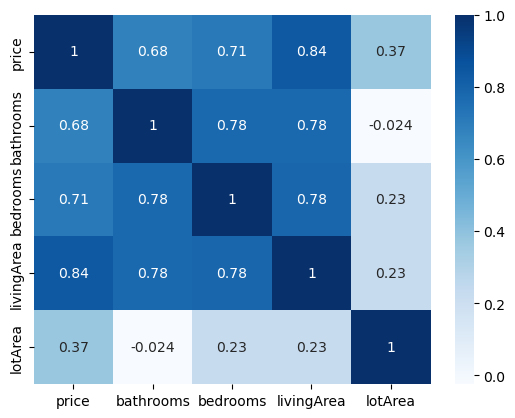

In [16]:
import numpy as np
import seaborn as sns
%matplotlib inline

sns.heatmap(sold_df.corr(numeric_only=True), annot = True, cmap="Blues")

There strongest areas of correlation seem to be between the price vs living area of a home, the number of bedrooms and bathrooms vs living area, as well as the number of bedrooms vs the number of bathrooms in a home. The lot area correlations are really low, probably caused by the many null values in that column. These null values bring in a lot of zeros, which will dilute the correlation between lot area and anything else. 

<Axes: >

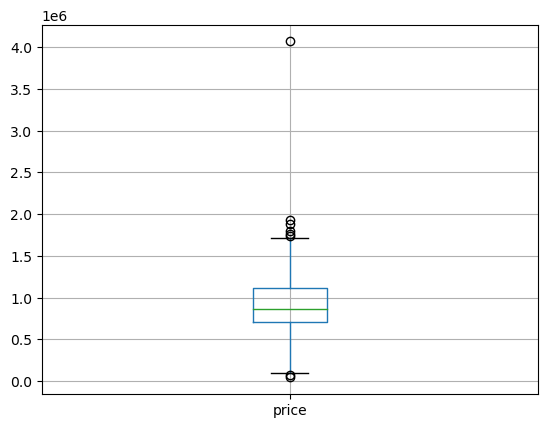

In [46]:
sold_df.boxplot("price")

<Axes: >

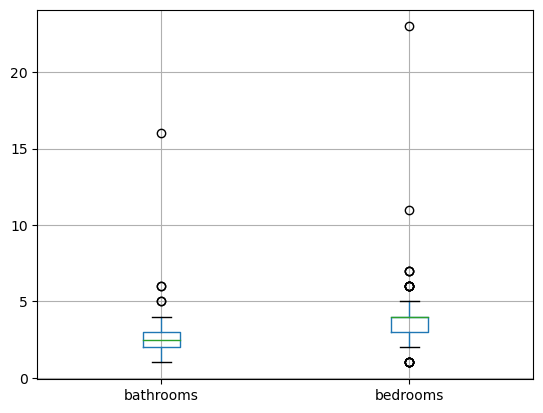

In [47]:
sold_df.boxplot(column=['bathrooms', 'bedrooms'])

<Axes: >

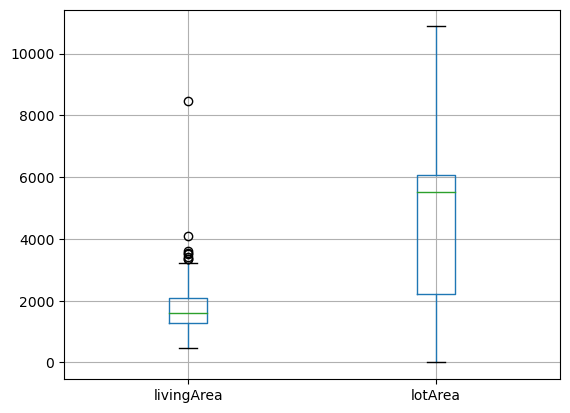

In [48]:
sold_df.boxplot(column=['livingArea', 'lotArea'])

### Median Price of Homes Sold

dateSold
2022-03     888950.0
2022-04     862500.0
2022-05     945000.0
2022-06     955000.0
2022-07     825000.0
2022-08     872500.0
2022-09     875000.0
2022-10     757500.0
2022-11     805000.0
2022-12     810000.0
2023-01     805000.0
2023-02     785000.0
2023-03     832500.0
2023-04     898500.0
2023-05    1082500.0
2023-06     861944.0
2023-07     992500.0
2023-08     913500.0
2023-09     920000.0
2023-10    1257500.0
Name: price, dtype: float64

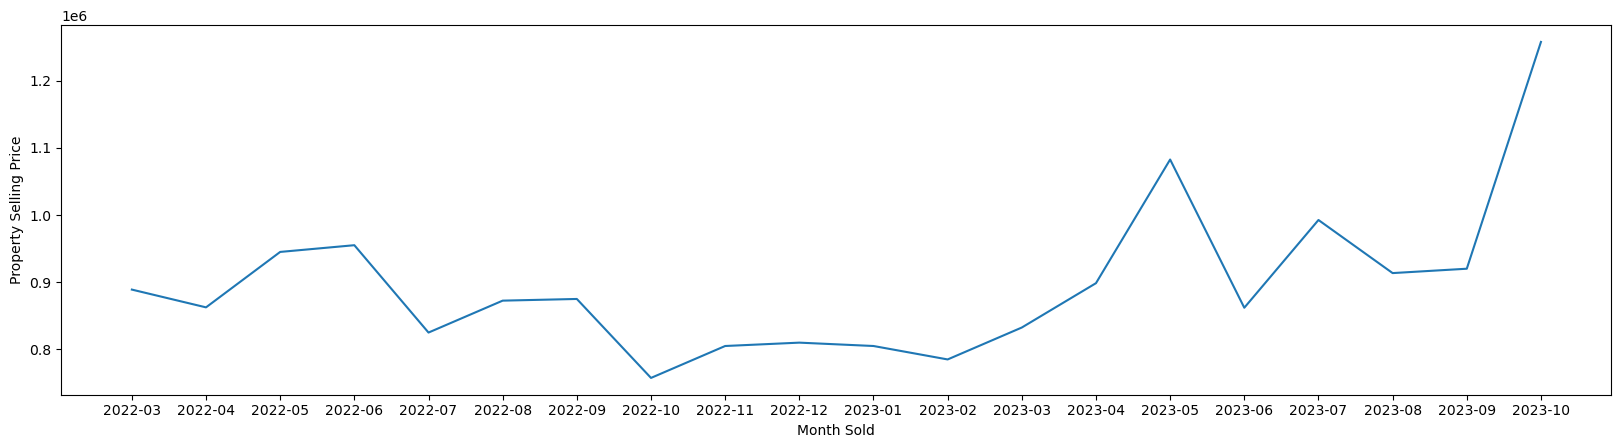

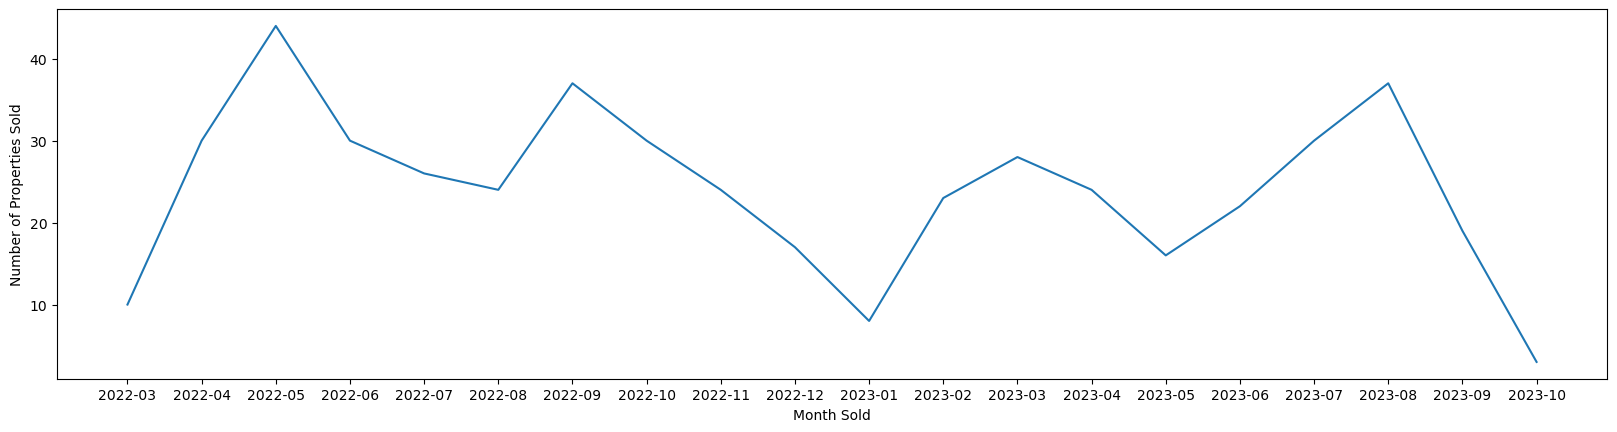

In [73]:
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()

# grouping all of the listings by the month to make the graph smoother. The price will be grouped as the median price. 
df = sold_df.groupby(pd.to_datetime(sold_df.dateSold).dt.to_period('M'))['price'].median()

# changing the index type so that the pyplot actually plots the graph.
df.index = df.index.astype(str)



plt.figure().set_figwidth(20)
plt.xlabel('Month Sold')
plt.ylabel('Property Selling Price')

plt.plot(df)

plt.show()

df1 = sold_df.groupby(pd.to_datetime(sold_df.dateSold).dt.to_period('M'))['price'].count()
df1.index = df.index.astype(str)
plt.figure().set_figwidth(20)
plt.xlabel('Month Sold')
plt.ylabel('Number of Properties Sold')

plt.plot(df1)
plt.show()


Looking at the graph above, we find that there is an upward trend as time passses. During the months of July until February, the median home price was relatively low. Using the second graph, we find that there seems to be a correlation between the number of houses sold and the median selling price. For example, around January and February, the number of houses sold is relatively low, and the property selling price also is very low, suggesting that only a few, cheaper homes were sold during that time period. Between September 2023 and October 2023, we find that the median selling price and the number of properties sold is inversely proportional, suggesting that the median price of houses sold in October are abnormally high due to the fact that we don't have many houses sold in the month of October yet. 


- for each current address
    - compare all the variables that address has to all sold listings with similar variable types
    - determine if it's below or above the trendline for that kind of listing 

## Modeling
In this next section, we will use a random forest to model our data and predict house prices. We use a random forest, attempting to average our predictions from the many features that come with housing data. 

In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# target object is price
y = sold_df.price

# features used
features = ['bedrooms', 'bathrooms', 'livingArea', 'lotArea', 'dateSold']
X = sold_df[features]
one_hot = pd.get_dummies(sold_df['homeType'])
X = pd.concat([X, one_hot], axis = 1, join = 'inner')

# replace all the NaN values with 0 since some properties are not sold with the land. 
X = X.fillna(0)
X['dateSold'] = X['dateSold'].apply(lambda x: x.toordinal())


# split the data into trainig and validation
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# defining the model, with random state set to 1.
model = RandomForestRegressor(random_state=1)

# fit the model
model.fit(train_X, train_y)

# make predictions and calculate mean absolute error
val_predictions = model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation mean absolute error for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

Validation mean absolute error for best value of max_leaf_nodes: 84,843


Our model will be able to predict home value in the range of + or - 105,958. Considering the median home value was $920,000 in September, this model's confidence interval is 88.5%. Since a statistically significance of 95% is generally desired, this model is not very useful for us. One way that this model might become more significant would be to increase our data set to include other zipcodes. This would increase the number of data points our model has to train and validate with as well as introduce zipcode as a new feature, which might increase the p-value of our model. 

Just for fun, let's use our model to predict house prices in our current_df dataset. 

In [18]:
current_df = current_df.rename(columns={"lotAreaValue":"lotArea"})

current_df = current_df.drop(index=current_df[current_df.homeType == 'LOT'].index)

# features used
features = ['bedrooms', 'bathrooms', 'livingArea', 'lotArea', 'dateSold']
predict_X = current_df[features]
one_hot = pd.get_dummies(current_df['homeType'])
predict_X = pd.concat([predict_X, one_hot], axis = 1, join = 'inner')

# replace 'None' in dateSold with our current date.
predict_X['dateSold'] = pd.to_datetime("2023-10-06")
predict_X['dateSold'] = predict_X['dateSold'].apply(lambda x: x.toordinal())

# replace all the NaN values with 0 since some properties are not sold with the land. 
predict_X = predict_X.fillna(0)

#predict using model
current_predictions = model.predict(predict_X)

# add a new column for the predictions, selling price, and street address
predict_X['predictions'] = current_predictions.tolist()
predict_X['sellingPrice'] = current_df['price']
predict_X['streetAddress'] = current_df['streetAddress']
predict_X['zipcode'] = current_df['zipcode']

# filter and show only the properties where the predicted value is higher than the selling price. 
filter = predict_X['predictions'] >= predict_X['sellingPrice']

buy_these = predict_X.where(filter)
buy_these = buy_these.dropna()
display(buy_these.sort_values('zipcode'))
print(len(buy_these))

,bedrooms,bathrooms,livingArea,lotArea,dateSold,CONDO,MANUFACTURED,MULTI_FAMILY,SINGLE_FAMILY,TOWNHOUSE,predictions,sellingPrice,streetAddress,zipcode
14,3.0,2.0,1189.0,6036.0,738799.0,0.0,0.0,0.0,1.0,0.0,868880.00,725000.0,7124 El Dorado Dr,90620
20,3.0,2.0,1140.0,6000.0,738799.0,0.0,0.0,0.0,1.0,0.0,870860.00,858000.0,7943 La Mona Cir,90620
40,3.0,2.0,1155.0,6000.0,738799.0,0.0,0.0,0.0,1.0,0.0,867760.00,775000.0,6547 San Homero Way,90620
52,4.0,3.0,2115.0,6700.0,738799.0,0.0,0.0,0.0,1.0,0.0,1236028.88,1064000.0,6171 Robin Way,90620
56,3.0,2.0,1150.0,0.0,738799.0,0.0,0.0,0.0,0.0,1.0,637905.00,579999.0,7131 Santa Inez Cir,90620
2,3.0,3.0,2037.0,5000.0,738799.0,0.0,0.0,0.0,1.0,0.0,1218530.00,1189900.0,5031 Pine Cir,90623
73,2.0,1.0,928.0,1259.0,738799.0,1.0,0.0,0.0,0.0,0.0,599890.00,559000.0,5097 Via Brenda,90623
19,5.0,3.0,2863.0,5250.0,738799.0,0.0,0.0,0.0,1.0,0.0,1399220.99,1249000.0,5771 Warwick Cir,90623
81,4.0,3.0,2532.0,3504.0,738799.0,0.0,0.0,0.0,1.0,0.0,1338170.00,1250000.0,6385 Stanford Ct,90630
5,3.0,2.0,1124.0,6000.0,738799.0,0.0,0.0,0.0,1.0,0.0,869210.00,849900.0,9421 Lime Cir,90630


23


Looking at the predicted models, we find something very interesting! We forgot to remove the current listings located in a different zipcode, but keeping it gave us results worth looking into. Out of the 82 current listings, we find that only 26 of these listings had predicted values greater than the current selling price. This would suggest that these properties are worth purchasing. However, looking at the zipcode, we find that only 7 properties in the 90630 area are considered good buys. Fortunately, within that criteria, the predictions are pretty close, which suggests that the model is relatively accurate. The fact that the majority of the properties on this list are in other zipcodes suggests that the zipcode has a significant impact on the value of a home. Going back to the data scraping portion of this project and increasing our field of view to include data from surrounding zipcodes might provide greater insight on which properties would provide better returns. 

** we can look at the difference between the predicted value and the selling price and if it's greater than 105000, then the property might actually be worth purchasing!